In [1]:
# %load_ext is safe to repeatedly run in a Jupyter notebook; it will just ignore duplicates.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np

import torch
from torch import Tensor, nn, optim 

from physics import ho_variational_loss
from model import MLP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### 1️⃣ Model and collocation points and initial loss

In [3]:
# Re-run this cell whenever you want a fresh, random network.
torch.manual_seed(0)


# 1. Build the network
model: nn.Module = MLP(hidden=64, device=device) 
model.to(device)
model.eval()        # inference mode (no dropout/BN), BUT gradients on

# 2. Create 64 collocation points in [0, 2pi]
n_points = 64
t_collocation: Tensor = 2 * torch.pi * torch.rand(n_points, 1, device=device)

# 3. Compute the physics-informed loss
initial_loss = ho_variational_loss(model, t_collocation)
print(f"Initial variational loss: {initial_loss.item():.6f}")

Initial variational loss: 1.233754


### 2️⃣ Training loop

In [4]:
# ----- hyper-parameters -------------------------------------------------
lr          = 1e-3
epochs      = 3_000
omega       = 1.0
log_every   = 400
# -----------------------------------------------------------------------

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    loss = ho_variational_loss(model, t_collocation, omega=omega)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % log_every == 0 or epoch == 1:
        print(f"epoch {epoch:4d} | loss = {loss.item():.6e}")

epoch    1 | loss = 1.233754e+00
epoch  400 | loss = 4.796770e-05
epoch  800 | loss = 1.436156e-05
epoch 1200 | loss = 4.420874e-06
epoch 1600 | loss = 9.125824e-04
epoch 2000 | loss = 6.487030e-07
epoch 2400 | loss = 3.022926e-07
epoch 2800 | loss = 4.163746e-03


### 3️⃣ Loss curve

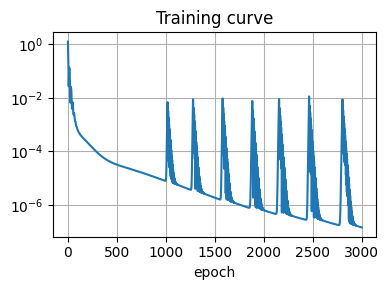

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("epoch")
plt.title("Training curve")
plt.grid(True)
plt.tight_layout()
plt.show()

### 4️⃣ Compare network vs. analytic solution

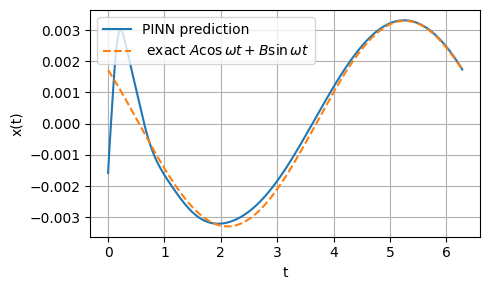

In [6]:
# Dense grid for visualization
t_dense = torch.linspace(0, 2 * torch.pi, 500, device=device).view(-1, 1)
with torch.no_grad():
    x_pred = model(t_dense).cpu().squeeze()
    
# Fit the two unknown constants (A, B) of the analytic solution
# x(t) = A * cos(omega*t) + B * sin(omega*t) using least squares.
t_np = t_dense.cpu().numpy()
W    = np.column_stack([np.cos(omega * t_np), np.sin(omega * t_np)])
A_B, *_ = np.linalg.lstsq(W, x_pred.numpy(), rcond=None)    # [A, B]

x_exact = torch.tensor(W @ A_B, dtype=x_pred.dtype)

plt.figure(figsize=(5, 3))
plt.plot(t_dense.cpu(), x_pred,  label="PINN prediction")
plt.plot(t_dense.cpu(), x_exact, label=" exact $A\\cos\\omega t+B\\sin\\omega t$", ls="--")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Figure Analysis
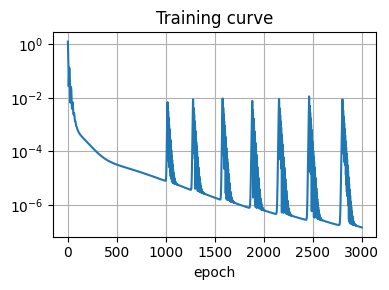

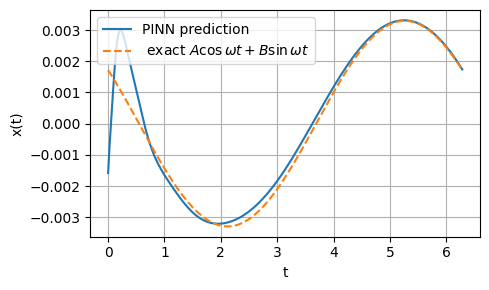